In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%precision 4

'%.4f'

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

Text(0, 0.5, 'Number Thallium atoms')

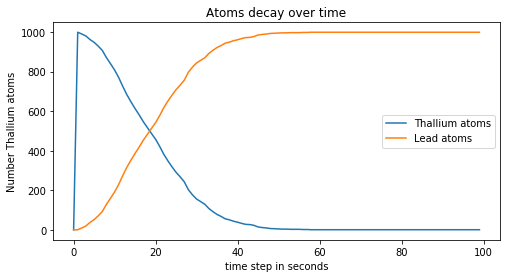

In [2]:
import numpy as np
T = 3.052*60
N = 1000
t = 100
Nt = np.arange(t)
Np = np.arange(t)

def p(x):
    return 1-2**(-x/T)

for i in range(1,t):
    for atom in range(1,N):
        if (np.random.rand() <= p(i)):
            N = N - 1
    Nt[i] = N
    Np[i] = 1000 - N

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Nt, label = 'Thallium atoms')
ax.plot(Np, label = 'Lead atoms')
ax.legend()
plt.title('Atoms decay over time')
plt.xlabel('time step in seconds')
plt.ylabel('Number Thallium atoms')

Text(0, 0.5, 'Number of atoms')

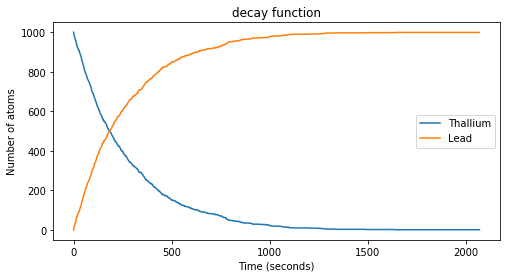

In [3]:
TL = N
PB = 0

# inverse transform method
def pdf(t):
    return 2**(-t/T)*np.log(2)/T

def cdf(t):
    return 1 - 2**(-t/T)

def icdf(p):
    return -np.log2(1-p)*T

TL = 1000
PB = 0

res = icdf(np.random.random(size=(TL,)))
res.sort()

hist = [[TL,PB]]
limit = int(np.round(res.max()))
for sec in range(1,limit):
    if TL <= 0: break
    
    dec = res[ res >= sec-1]
    dec = dec[dec < sec]
    cnt = len(dec)
    
    TL -= cnt
    PB += cnt
    hist.append([TL,PB])

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(hist)
ax.legend(['Thallium','Lead']);
plt.title('decay function')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of atoms')

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

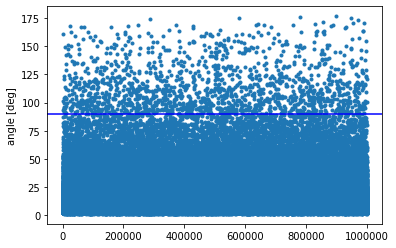

number of particles that bounce back 1539
fraction of particles that bounce back 0.001539


In [4]:
def tetha(Z, E, b, electron):
    eps0 = 8.85*1e-12 # F/m
    return 2*np.arctan(Z*electron**2 / (2*np.pi*eps0*E*b))

Z = 79
electron = 1.60217*(10**-19)
E = 7.7*1e6*electron 

a0 = 5.29177*(10**-11) #pm -> m bohr radius
sigma = a0/100


x = np.random.rand(10**6)


b = np.sqrt(-2*(sigma)**(2)*np.log(1-x)) 
angle = tetha(Z, E, b, electron)

plt.plot(np.rad2deg(angle), '.') 
plt.axhline(y=90, color='b', linestyle='-')
plt.ylabel('angle [deg]')
plt.show()

print('number of particles that bounce back', angle[angle > np.pi/2].size)
print('fraction of particles that bounce back', angle[angle > np.pi/2].size/angle.size)

3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

C:\Users\Abanoub\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
C:\Users\Abanoub\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sin
  """


Monte Carlo hit/miss method 1.4492  error 0.2754 error2 0.0021999999999999797
Monte Carlo hit/miss method 1.4538950616300794 error 0.2730524691849604 error2 0.002495061630079398
error2 wrt value from wolframalpha 1.4514


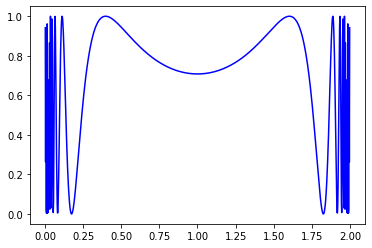

In [5]:
# 1D CASE
np.random.seed(1234)

def f(x):
    return np.sin(1/(x*(2-x)))**2

a = 0
b = 2
x=np.linspace(a,b,1000)
plt.plot(x,f(x),'b-')

# 1 hit/miss method - Monte Carlo integration
N = 100000
count = 0
for i in range(N):
    x = b*np.random.random()
    y = np.random.random()
    if y < f(x): # if the random sample is above count it, otherwise don't
        count += 1
    
I = (b - a)/N*count
print('Monte Carlo hit/miss method',I, ' error', 1-count/N, 'error2', np.abs(I-1.4514))

# 2 mean value method - Monte Carlo integration
count = 0
for i in range(N):
    # uniformly draw random samples from the domain
    x = b*np.random.random()
    count += f(x)
I = (b - a)/N*count
print('Monte Carlo hit/miss method',I, 'error', 1-count/N, 'error2', np.abs(I-1.4514))
print('error2 wrt value from wolframalpha', 1.4514)

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [6]:
N = 10000
def r():
    return np.random.random()
def area(x, y):
    return x**2 + y**2

c = 0
for i in range(N):
    if area(r(), r()) <= 1: 
        c += 1
4*c/N





3.1528

In [7]:
# 10D
def area10D(x1, x2, x3, x4, x5, x6, x7, x8, x9, x10):
    return x1**2 + x2**2 + x3**2 + x4**2 + x5**2 + x6**2 + x7**2 + x8**2 + x9**2 + x10**2

c = 0
for i in range(N):
    if area10D(r(), r(), r(), r(), r(), r(), r(), r(), r(), r()) <= 1: 
        c += 1
1000*c/N

2.8000

5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

C:\Users\Abanoub\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  


integral with importance sampling 0.7597806552889722


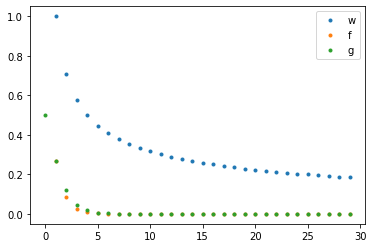

In [8]:
def w(x):
    return x**(-1/2)
    
def integralW(x):
    return 2*x**(1/2)

def f(x):
    return w(x)/(np.e**x+1)

def g(x):
    return 1/(np.e**x+1)

plt.plot(np.arange(0,30),w(np.arange(0,30)), '.')
plt.plot(np.arange(0,30),f(np.arange(0,30)), '.')
plt.plot(np.arange(0,30),g(np.arange(0,30)), '.')
plt.legend(['w','f','g'])

#constants
a = 0
b = 1
N = 10**6
x = np.random.rand(N)

I = 1/N*np.sum(f(x)/w(x))*(integralW(b)-integralW(a))
print('integral with importance sampling', I)